# Performance Analysis

In this notebook, we analyse the performance of our 
with different paramters.

All tests are done using cuda on an [Nvidia RTX A6000](https://www.nvidia.com/en-us/design-visualization/rtx-a6000/)

## Imports and misc

In [1]:
import warnings
import math
import itertools as it

import networkx as nx
import torch
from torch import Tensor
from  torch.utils import benchmark
import numpy as np
from numpy.random import default_rng
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from ot_markov_distances import sinkhorn_distance, discounted_wl_infty, discounted_wl_k
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov

from ot.bregman import sinkhorn_log as ot_sinkhorn_log
from ot import emd

device = torch.device("cuda:4")
rng = default_rng(seed=10)


## Data

We’ll use fixed-out-degree Erdős–Rényi (ER) graphs to run our tests:
The algorithm speed should only depend on the size and maximum degree of the graphs and the ER model allows us to vary those parameters

In [2]:
def get_batch(batch):
    match batch:
        case None:
            return ()
        case int():
            return (batch,)
        case _:
            return batch

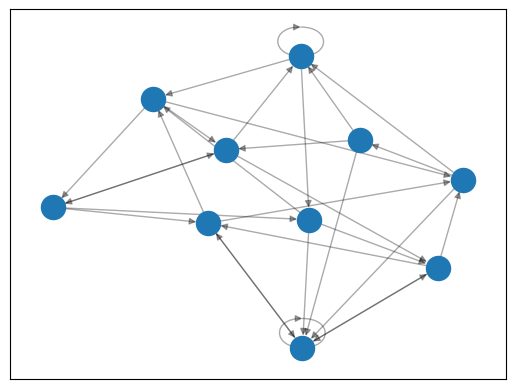

In [3]:
def generate_er_markov_chains(n, d, batch=None, device=device, has_to_be_connected=False):
    batch = get_batch(batch)
    
    M = np.zeros((*batch, n, n))
    for row in M.reshape(-1, n):
        row[rng.choice(n, d, replace=False)] = 1 / d
    if has_to_be_connected and not nx.is_strongly_connected(nx.from_numpy_array(M, create_using=nx.DiGraph)):
        return generate_er_markov_chains(n, d, batch, device, has_to_be_connected)
    M = torch.asarray(M, device=device, dtype=torch.float)    
    #M = torch.rand((*batch, n, n), device=device)
    #M = M < p
    #M = M | torch.eye(n, device = device, dtype=torch.bool)
    
    #M = M / M.sum(dim=-1, keepdim=True)
    return M

#enerate_er_markov_chains(10, 3, batch=2)
draw_markov(generate_er_markov_chains(10, 3, has_to_be_connected=True))

In [4]:
def uniform_distribution(n, batch=None, device=device):
    batch = get_batch(batch)
    u = torch.ones((*batch, n), dtype=torch.float, device=device)
    u = u / n
    return u

In [5]:
def random_cost_matrix(n, m, label_size=10, batch=None, device=device):
    batch = get_batch(batch)
    l1 = torch.randn((*batch, n, 1, label_size),  dtype=torch.float, device=device)
    l2 = torch.randn((*batch, 1, m, label_size),  dtype=torch.float, device=device)
    C = (l1 - l2).square().sum(-1)
    return C

In [6]:
n1 = 10
n2 = 10
d1 = 3
d2 = 4
batch = 5

er0 = generate_er_markov_chains(n1, d1, batch=5)
er1 = generate_er_markov_chains(n2, d2, batch=5)

dist0 = uniform_distribution(n1, batch=batch)
dist1 = uniform_distribution(n2, batch=batch)

C = random_cost_matrix(n1, n2, batch=batch)

discounted_wl_infty(er0, er1, C, dist0, dist1, delta=.1, x_is_sparse=True, y_is_sparse=True)

tensor([14.6865, 22.8702, 14.9706, 18.4375, 16.7359], device='cuda:4')

First let’s warm up GPU

In [7]:
setup_experiment = """
from __main__ import discounted_wl_infty, generate_er_markov_chains, uniform_distribution, random_cost_matrix

er0 = generate_er_markov_chains(n1, d1, batch=batch)
er1 = generate_er_markov_chains(n2, d2, batch=batch)

dist0 = uniform_distribution(n1, batch=batch)
dist1 = uniform_distribution(n2, batch=batch)

C = random_cost_matrix(n1, n2, batch=batch)
"""

stmt_experiment = "discounted_wl_infty(er0, er1, C, dist0, dist1, delta=.1, x_is_sparse={}, y_is_sparse={})"

def do_experiment(label="exp", min_run_time=10, x_is_sparse=True, y_is_sparse=True, **kwargs):
    timer = benchmark.Timer(
        stmt=stmt_experiment.format(x_is_sparse, y_is_sparse),
        setup=setup_experiment,
        globals=kwargs,
        num_threads = torch.get_num_threads(),
        label=label
    )
    
    result = timer.blocked_autorange(min_run_time=min_run_time)
    return result
    

In [8]:
def experiments_to_pandas(experiments, batch=1, **values):
    batches = values.get("batch_size", [batch] * len(experiments))
    raw_times = [np.asarray(exp.times) / batch for exp, batch in zip(experiments, batches)]
    list_values = [dict(zip(values,t)) for t in zip(*values.values())]
    experiments_labelled = [
        pd.DataFrame(raw_times[i], columns=["time (s)"]).assign(**values)
        for i, values in enumerate(list_values)
    ]
    return pd.concat(experiments_labelled).reset_index()


OK now that we’ve tested that it works, time to make some plots.

## Low degree, big graphs

In [9]:
%store -r graph_sizes_experiments
graph_sizes = [1 << i for i in range(4, 11)]
if "graph_sizes_experiments" not in vars():
    graph_sizes_experiments = [None] * len(graph_sizes)
d1 = 3
d2 = 4
batch = 5

for i, graph_size in enumerate(tqdm(graph_sizes)):
    if graph_sizes_experiments[i] is not None:
        continue
    exp = do_experiment(
        d1=d1,
        d2=d2,
        batch=batch,
        n1=graph_size,
        n2=graph_size,
        label=f"low_degree_graphs, {graph_size=}",
        min_run_time=100
    )
    import gc; gc.collect()
    torch.cuda.empty_cache()
    graph_sizes_experiments[i] = exp
%store graph_sizes_experiments

  0%|          | 0/7 [00:00<?, ?it/s]

Stored 'graph_sizes_experiments' (list)


In [10]:
%store -r graph_batch_sizes_experiments
d1 = 3
d2 = 4
batch = 5

graph_sizes = [1 << i for i in range(4, 11)]
batch_sizes = [5, 10, 20]
graph_sizes, batch_sizes = zip(*it.product(graph_sizes, batch_sizes))
if "graph_batch_sizes_experiments" not in vars():
    graph_batch_sizes_experiments = [None] * len(graph_sizes)



for i, graph_size, batch in zip(it.count(), tqdm(graph_sizes), batch_sizes):
    if graph_batch_sizes_experiments[i] is not None:
        continue
    exp = do_experiment(
        d1=d1,
        d2=d2,
        batch=batch,
        n1=graph_size,
        n2=graph_size,
        label=f"low_degree_graphs, {graph_size=}",
        min_run_time=100
    )
    import gc; gc.collect()
    torch.cuda.empty_cache()
    graph_batch_sizes_experiments[i] = exp
%store graph_batch_sizes_experiments

  0%|          | 0/21 [00:00<?, ?it/s]

Stored 'graph_batch_sizes_experiments' (list)


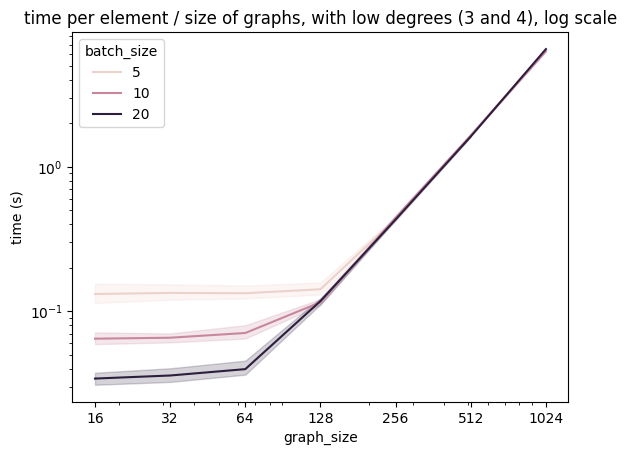

In [11]:
import matplotlib.ticker as mpl_ticker
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks(np.unique(graph_sizes), np.unique(graph_sizes) , minor=False)
sns.lineplot(
    data=experiments_to_pandas(graph_batch_sizes_experiments, graph_size = graph_sizes, batch_size=batch_sizes),
    y="time (s)",
    x="graph_size",
    hue="batch_size",
    errorbar=("pi", 95),
    markers=True,

)

plt.title("time per element / size of graphs, with low degrees (3 and 4), log scale");

same one without log scale

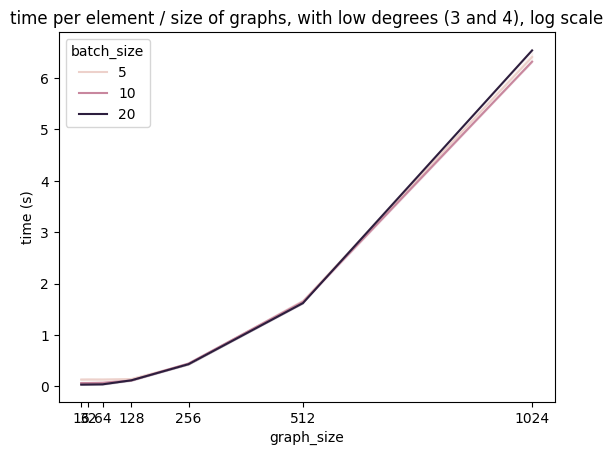

In [12]:
import matplotlib.ticker as mpl_ticker
plt.gca().set_xticks(np.unique(graph_sizes), np.unique(graph_sizes) , minor=False)
sns.lineplot(
    data=experiments_to_pandas(graph_batch_sizes_experiments, graph_size = graph_sizes, batch_size=batch_sizes),
    y="time (s)",
    x="graph_size",
    hue="batch_size",
    errorbar=("pi", 95),
    markers=True,

)

plt.title("time per element / size of graphs, with low degrees (3 and 4), log scale");

In [13]:
df = experiments_to_pandas(graph_batch_sizes_experiments, graph_size = graph_sizes, batch_size=batch_sizes)
df["time (s)"] /= df.batch_size
df[df.batch_size == 20].groupby("graph_size").median()

,index,time (s),batch_size
graph_size,,,
16,73.0,0.001700,20.0
32,69.5,0.001802,20.0
64,62.5,0.001967,20.0
128,21.0,0.005898,20.0
256,5.5,0.021579,20.0
512,1.5,0.081005,20.0
1024,0.0,0.326742,20.0


# Changing degrees

In [14]:
%store -r graph_degrees_experiments
batch = 5

graph_sizes = [1 << i for i in range(5, 9)]
degree_values = [5, 10, 20]
graph_sizes, degree_values = zip(*it.product(graph_sizes, degree_values))
if "graph_degrees_experiments" not in vars():
    graph_degrees_experiments = [None] * len(graph_sizes)



for i, graph_size, degree in zip(it.count(), tqdm(graph_sizes), degree_values):
    if graph_degrees_experiments[i] is not None:
        continue
    exp = do_experiment(
        d1=degree,
        d2=degree,
        batch=batch,
        n1=graph_size,
        n2=graph_size,
        label=f"low_degree_graphs, {graph_size=}",
        min_run_time=60
    )
    import gc; gc.collect()
    torch.cuda.empty_cache()
    graph_degrees_experiments[i] = exp
%store graph_degrees_experiments

  0%|          | 0/12 [00:00<?, ?it/s]

Stored 'graph_degrees_experiments' (list)


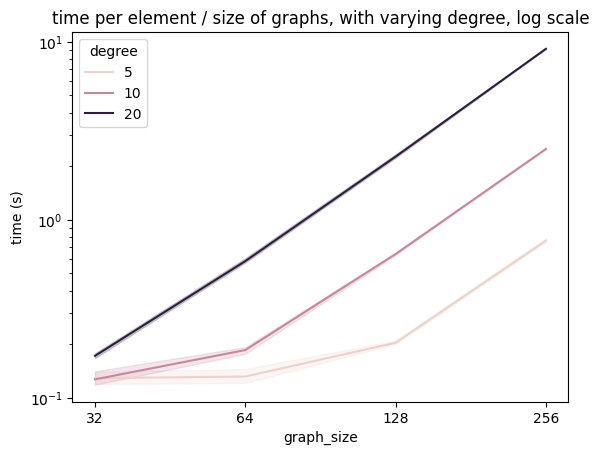

In [15]:
import matplotlib.ticker as mpl_ticker
plt.yscale("log")
plt.xscale("log")
plt.xticks([], minor=True)
plt.xticks([], minor=False)
plt.xticks(np.unique(graph_sizes), np.unique(graph_sizes) , minor=False)

sns.lineplot(
    data=experiments_to_pandas(graph_degrees_experiments, batch=batch, graph_size = graph_sizes, degree=degree_values),
    y="time (s)",
    x="graph_size",
    hue="degree",
    errorbar=("pi", 95),
    markers=True,

)


plt.title("time per element / size of graphs, with varying degree, log scale");

In [16]:
df = experiments_to_pandas(graph_degrees_experiments, batch=batch, graph_size = graph_sizes, degree=degree_values)
df["time (s)"] /= batch
df[(df.graph_size == 64)].groupby("degree").agg({"time (s)": "median", "graph_size":"first"})



,time (s),graph_size
degree,,
5,0.026186,64
10,0.036986,64
20,0.116910,64


## One dense graph and one sparse graph

In [17]:
%store -r dense_graphs_experiments
batch = 5
sparse_size = 64
sparse_degree = 5
dense_graph_sizes = [10, 20, 30, 40 , 50, 60, 70, 80]
if "dense_graphs_experiments" not in vars():
    dense_graphs_experiments = [None] * len(dense_graph_sizes)

for i, graph_size in zip(it.count(), tqdm(dense_graph_sizes)):
    if dense_graphs_experiments[i] is not None:
        continue
    exp = do_experiment(
        d1=graph_size,
        d2=sparse_degree,
        batch=batch,
        n1=graph_size,
        n2=sparse_size,
        x_is_dense=False,
        label=f"dense_graph, {graph_size=}",
        min_run_time=60
    )
    import gc; gc.collect()
    torch.cuda.empty_cache()
    dense_graphs_experiments[i] = exp
%store dense_graphs_experiments

  0%|          | 0/8 [00:00<?, ?it/s]

Stored 'dense_graphs_experiments' (list)


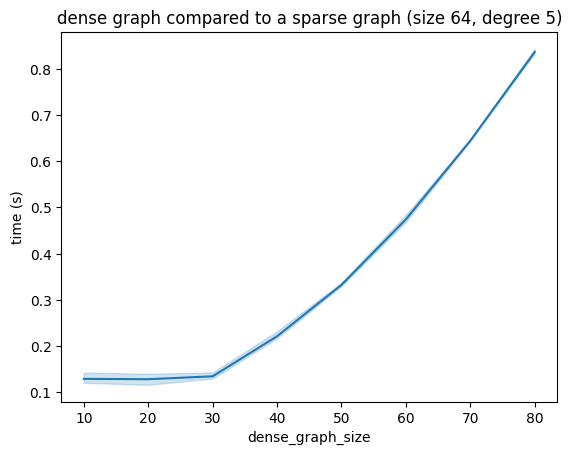

In [18]:
import matplotlib.ticker as mpl_ticker
#plt.yscale("log")
#plt.xscale("log")
plt.xticks([], minor=True)
plt.xticks([], minor=False)
plt.xticks(np.unique(dense_graph_sizes), np.unique(dense_graph_sizes) , minor=False)

sns.lineplot(
    data=experiments_to_pandas(dense_graphs_experiments, batch=batch, dense_graph_size = dense_graph_sizes),
    y="time (s)",
    x="dense_graph_size",
    errorbar=("pi", 95),
    markers=True,

)


plt.title(f"dense graph compared to a sparse graph (size {sparse_size}, degree {sparse_degree})");

## Backward pass

In [19]:
setup_experiment_backward = """
from __main__ import discounted_wl_infty, generate_er_markov_chains, uniform_distribution, random_cost_matrix

er0 = generate_er_markov_chains(n1, d1, batch=batch).requires_grad_()
er1 = generate_er_markov_chains(n2, d2, batch=batch).requires_grad_(False)

dist0 = uniform_distribution(n1, batch=batch).requires_grad_()
dist1 = uniform_distribution(n2, batch=batch).requires_grad_(False)

C = random_cost_matrix(n1, n2, batch=batch).requires_grad_()
d = discounted_wl_infty(er0, er1, C, dist0, dist1, delta=.1, x_is_sparse=False, y_is_sparse=True).sum()
"""

stmt_experiment_backward = "d.backward()"

def do_experiment_backward(label="exp", min_run_time=10, **kwargs):
    timer = benchmark.Timer(
        stmt=stmt_experiment_backward,
        setup=setup_experiment_backward,
        globals=kwargs,
        num_threads = torch.get_num_threads(),
        label=label
    )
    
    result = timer.blocked_autorange(min_run_time=min_run_time)
    return result
    
do_experiment_backward(
        d1=20,
        d2=5,
        batch=batch,
        n1=20,
        n2=64,
        label=f"backward",
        min_run_time=60

)

backward
setup:
  from __main__ import discounted_wl_infty, generate_er_markov_chains, uniform_distribution, random_cost_matrix

  er0 = generate_er_markov_chains(n1, d1, batch=batch).requires_grad_()
  er1 = generate_er_markov_chains(n2, d2, batch=batch).requires_grad_(False)

  dist0 = uniform_distribution(n1, batch=batch).requires_grad_()
  dist1 = uniform_distribution(n2, batch=batch).requires_grad_(False)

  C = random_cost_matrix(n1, n2, batch=batch).requires_grad_()
  d = discounted_wl_infty(er0, er1, C, dist0, dist1, delta=.1, x_is_sparse=False, y_is_sparse=True).sum()

  Median: 24.31 ms
  IQR:    1.07 ms (23.93 to 25.00)
  2436 measurements, 1 runs per measurement, 64 threads